In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv,norm
from scipy.special import beta,betainc
from sklearn.linear_model import LassoLars, lars_path

import random
from sklearn.model_selection import KFold # import KFold
from numpy import empty
from scipy import optimize
from sklearn.linear_model import Ridge

In [7]:
# import mean and covariance matrix of the 100 assets and 3 factors
mu = pd.read_csv('mean.csv',header=None)
S = pd.read_csv('var.csv',header=None) #var-cov matrix
# mu = mu.drop(0,axis=1)
# S = S.drop(0,axis=1)
# mu = np.asarray(mu).flatten()
# S = np.asarray(S)
S.head()


,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
0,1,0.009659,0.003798,0.008886,0.004038,0.003926,0.004397,0.002951,0.005375,0.006566,...,0.001631,0.001633,0.004359,0.002939,0.000862,0.004836,0.003038,0.003317,0.000718,0.000814
1,2,0.003798,0.007883,0.006058,0.002729,0.002841,0.003125,0.002145,0.003683,0.004461,...,0.001255,0.001155,0.003158,0.002076,0.000608,0.003476,0.002244,0.002360,0.000465,0.000380
2,3,0.008886,0.006058,0.025043,0.006775,0.006327,0.007223,0.004697,0.009257,0.011660,...,0.002405,0.002938,0.006915,0.004780,0.001549,0.007681,0.004638,0.005393,0.001004,0.002009
3,4,0.004038,0.002729,0.006775,0.007459,0.002674,0.003126,0.002015,0.004059,0.005083,...,0.000974,0.000966,0.003040,0.002186,0.000517,0.003492,0.002087,0.002394,0.000859,0.000876
4,5,0.003926,0.002841,0.006327,0.002674,0.005961,0.003306,0.002284,0.003857,0.004619,...,0.001370,0.001361,0.003328,0.002142,0.000713,0.003607,0.002349,0.002471,0.000294,0.000376


In [20]:
# Set parameters for the optimization problem
sigma = 0.04
N = 103
T = 240
nobs = 100

In [21]:
os_s = np.zeros(nobs)
os_sr = np.zeros(nobs)
for i in range(nobs):
    r = np.random.multivariate_normal(mu,S,T) # 240 observaitions for array with size 103
    muh = np.mean(r,axis=0)
    Sh = np.cov(r,rowvar=False,ddof=0)
    wh = np.dot(inv(Sh),muh)
    wh = sigma/np.sqrt(np.dot(wh,muh))*wh
    os_s[i] = np.sqrt(np.dot(wh,S.dot(wh))) 
    os_sr[i] = np.sqrt(12)*np.dot(wh,mu)/os_s[i]

In [22]:
# Theoretical Maximum Sharpe ratio (annualized)
sr = np.sqrt(12*np.dot(mu,inv(S).dot(mu)))
sr

1.8824247694760523

### Q1

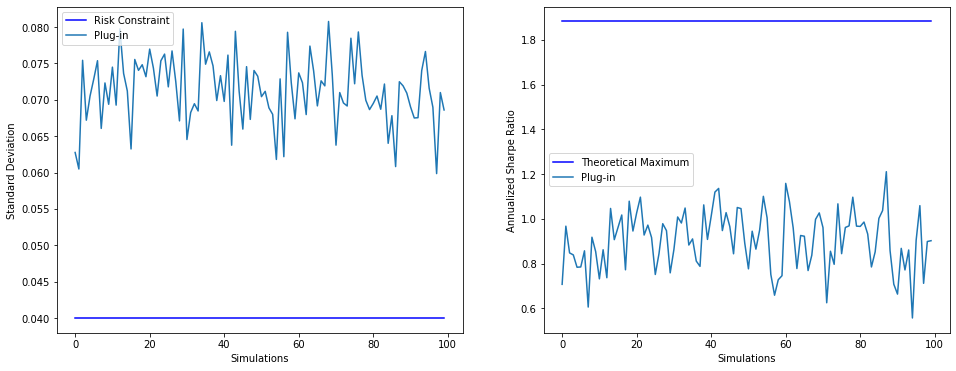

In [120]:
x = range(nobs)
y = np.ones(nobs)
plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.plot(x,y*sigma,'b-',x,os_s)
plt.xlabel('Simulations')
plt.ylabel('Standard Deviation')
plt.legend(['Risk Constraint','Plug-in'])

# plt.figure(figsize=(6,4))
plt.subplot(1, 2, 2)
plt.plot(x,y*sr,'b-',x,os_sr)
plt.xlabel('Simulations')
plt.ylabel('Annualized Sharpe Ratio')
plt.legend(['Theoretical Maximum','Plug-in'])
plt.show()


### Q2

In [23]:
#Methods 
np.random.seed(seed = 123)
def theta_adj(theta,N,T):
    a = N/2
    b = (T-N)/2
    theta_a = ((T-N-2)*theta-N)/T+2*theta**a*(1+theta)**(-(T-2)/2)/T/(betainc(a,b,theta/(1+theta))*beta(a,b))
    return theta_a

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_nearest_2d(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

os_s_LASSO = np.zeros(nobs)
os_sr_LASSO = np.zeros(nobs)
theta_adj_h = np.zeros(nobs)
r_c = np.zeros(nobs)
zeta_opt_vec = np.zeros(nobs)
wei_opt_vec = empty([nobs,103])

np.set_printoptions(precision=4, suppress = True)
for i in range(nobs):
    r = np.random.multivariate_normal(mu,S,T) # 240 observaitions for array with size 103
    r_og = r # store original r matrix for each simulation
    X = r    
    kf = KFold(n_splits=10,random_state=None, shuffle=False) # Define the split - into 10 folds 
    kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator
    
    zeta_opt = 0
    for train_index, test_index in kf.split(X):
#         print('TRAIN:', train_index, 'TEST:', test_index)
        X_train, X_test = X[train_index], X[test_index]
        r = X_train
        muh = np.mean(r,axis=0)
        Sh = np.cov(r,rowvar=False,ddof=0)
        theta_s_h = np.dot(muh,inv(Sh).dot(muh)) #annulized????
        theta_adj_h[i] = theta_adj(theta_s_h, N, T)
        r_c[i] =  sigma* ((1 + theta_adj_h[i])/np.sqrt(theta_adj_h[i]))

        x = r # 240 observations * 103 assets
        y = np.repeat(r_c[i], 240*0.9) #

        alphas, _, b1 = lars_path(x,y,method='lasso')
        zeta = norm(b1,1,axis=0)/norm(b1[:,-1],1) #??? 
        exc_ret_std= np.dot(X_test, b1).std(axis=0)
        nearest_sigma_idx = find_nearest(exc_ret_std, sigma)
        zeta_opt = zeta_opt + zeta[nearest_sigma_idx]
        
    zeta_opt_vec[i] = zeta_opt/10
    
    # use zeta_opt in original excess return portfolio r to find optimal weight
    muh_tlt = np.mean(r_og,axis=0)
    Sh_tlt = np.cov(r_og,rowvar=False,ddof=0)
    theta_s_h_tlt = np.dot(muh_tlt,inv(Sh_tlt).dot(muh_tlt)) 
    theta_adj_h_tlt = theta_adj(theta_s_h_tlt, N, T)
    r_c_tlt =  sigma* ((1 + theta_adj_h_tlt)/np.sqrt(theta_adj_h_tlt))
    
    x_tlt = r_og
    y_tlt = np.repeat(r_c_tlt, 240)
    
    alphas, _, b1 = lars_path(x_tlt,y_tlt,method='lasso')
    zeta_tlt = norm(b1,1,axis=0)/norm(b1[:,-1],1)
    [zeta_ind, zeta_val] =  find_nearest_2d(zeta_tlt, zeta_opt_vec[i])
    if zeta_val > zeta_opt_vec[i]:
        [zeta_up_ind, zeta_up_val] = [zeta_ind, zeta_val]
        [zeta_low_ind, zeta_low_val] = [zeta_ind - 1, zeta_tlt[zeta_ind - 1]]
    elif zeta_val < zeta_opt_vec[i]:
        [zeta_up_ind, zeta_up_val] = [zeta_ind + 1, zeta_tlt[zeta_ind + 1]]
        [zeta_low_ind, zeta_low_val] = [zeta_ind, zeta_val]
    else:
        zeta_low_val = zeta_up_val = zeta_val
        zeta_low_ind = zeta_up_ind = zeta_ind
    
    x = (zeta_opt_vec[i] - zeta_up_val) / (zeta_low_val - zeta_up_val)
    wei_opt_vec[i] = x*b1[ : , zeta_low_ind] + (1 - x)*b1[ : , zeta_up_ind]
    wh = wei_opt_vec[i]
    os_s_LASSO[i] = np.sqrt(np.dot(wh,S.dot(wh))) 
    os_sr_LASSO[i] = np.sqrt(12)*np.dot(wh,mu)/os_s_LASSO[i]

In [9]:
#Methods on paper
r = np.random.multivariate_normal(mu,S,T) # 240 observaitions for array with size 103
sigma = 0.04
Kfold = 10

def MAXSER(r,sigma,Kfold):
    T,N = r.shape
    muh = np.mean(r,axis=0)
    Sh = np.cov(r,rowvar=False,ddof=0)
    theta = np.dot(muh,inv(Sh).dot(muh))
    theta_a = theta_adj(theta,N,T)
    rc = (1 + theta_a)/np.sqrt(theta_a)*sigma
    y = rc * np.ones(T)
    _,_,b = lars_path(r, y,method = 'lasso')
    zeta0 = norm(b,1,axis=0)/norm(b[:,-1],1)
    zeta = np.zeros(Kfqold)
    T1 = np.fix(T/Kfold).astype(int) # = 24
    y1 = rc * np.ones(T-T1) # training set
    for i in range(Kfold):
        ind = range(i*T1,(i+1)*T1)
        r1 = np.delete(r,ind,axis=0) # training set
        _,_, b1 = lars_path(r1,y1,method='lasso')
        q = np.std(np.matmul(r[ind,:],b1),axis= 0,ddof=1) #test set of r
        j = np.argmin(np.abs(sigma-q))
        zeta[i] = norm(b1[:,j],1)/norm(b1[:,-1],1)
    zeta = np.mean(zeta)
    ind = np.min(np.argwhere(zeta0>zeta))
    q = (zeta - zeta0[ind-1])/(zeta0[ind]-zeta0[ind-1])
    w = (1-q)*b[:,ind-1]+q*b[:,ind]
    return w

os_s_LASSO_paper = np.zeros(nobs)
os_sr_LASSO_paper = np.zeros(nobs)

for i in range(100):
    r = np.random.multivariate_normal(mu,S,T) # 240 observaitions for array with size 103
    sigma = 0.04
    Kfold = 10
    wh = MAXSER(r, sigma, Kfold)
    os_s_LASSO_paper[i] = np.sqrt(np.dot(wh,S.dot(wh))) 
    os_sr_LASSO_paper[i] = np.sqrt(12)*np.dot(wh,mu)/os_s_LASSO_paper[i]

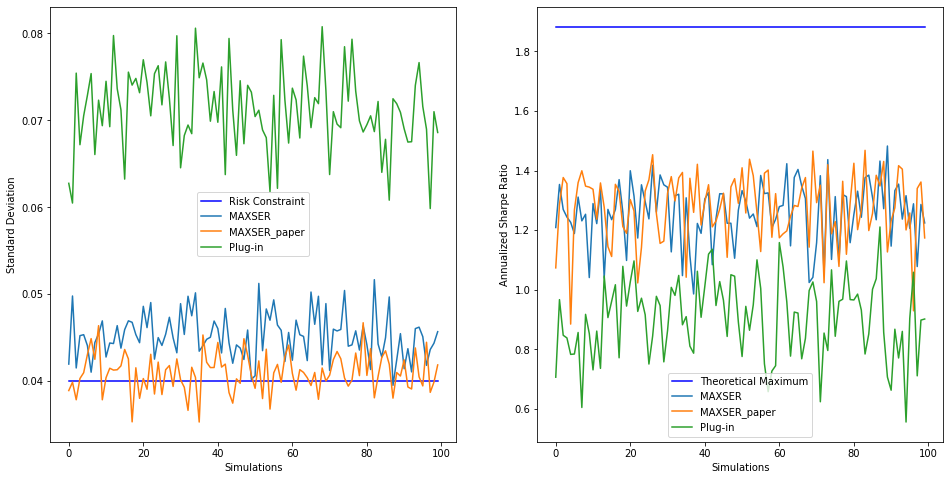

In [129]:
x = range(nobs)
y = np.ones(nobs)
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(x,y*sigma,'b-',x,os_s_LASSO, x, os_s_LASSO_paper, x, os_s)
plt.xlabel('Simulations')
plt.ylabel('Standard Deviation')
plt.legend(['Risk Constraint','MAXSER', 'MAXSER_paper', 'Plug-in'])
# plt.show()

# plt.figure(figsize=(8,6))
plt.subplot(1, 2, 2)
plt.plot(x,y*sr,'b-',x,os_sr_LASSO, x, os_sr_LASSO_paper, x, os_sr)
plt.xlabel('Simulations')
plt.ylabel('Annualized Sharpe Ratio')
plt.legend(['Theoretical Maximum','MAXSER','MAXSER_paper', 'Plug-in'])
plt.show()

### Q3

In [64]:
def ridge_sigma(lambd, r1, y1, ind, sigma): #weigth w
    r1_t = np.transpose(r1)
    w_h = np.matmul(inv(np.matmul(r1_t, r1) + lambd*np.identity(N)), np.dot(r1_t, y1))
    q = np.std(np.matmul(r[ind,:],w_h),axis= 0,ddof=1)
    f = q - sigma
    return f

In [138]:
np.random.seed(seed = 123)
def RIDGE(r,sigma,Kfold):
    T,N = r.shape
    muh = np.mean(r,axis=0)
    Sh = np.cov(r,rowvar=False,ddof=0)
    theta = np.dot(muh,inv(Sh).dot(muh))
    theta_a = theta_adj(theta,N,T)
    rc = (1 + theta_a)/np.sqrt(theta_a)*sigma
    y = rc * np.ones(T)
    lambd = np.zeros(Kfold)
    T1 = np.fix(T/Kfold).astype(int) # validation data
    y1 = rc * np.ones(T-T1) #training data
    for i in range(Kfold):
        ind = range(i*T1,(i+1)*T1) 
        r1 = np.delete(r,ind,axis=0) #delete row from r to get traning set r1
        a = 0
        b = 50
        args = (r1, y1, ind, sigma)
        lambd[i] = optimize.brentq(ridge_sigma, a, b, args)
    lambd = np.mean(lambd)
#     w = np.matmul(inv(np.matmul(np.transpose(r), r) + lambd*np.identity(N)), np.dot(np.transpose(r), y))
    reg = Ridge(alpha=lambd, fit_intercept=False, normalize=False)
    reg.fit(r, y)
    w = reg.coef_
    return w

nobs = 100
os_s_ridge = np.zeros(nobs)
os_sr_ridge = np.zeros(nobs)

for i in range(nobs):
    r = np.random.multivariate_normal(mu,S,T) # 240 observaitions for array with size 103
    sigma = 0.04
    Kfold = 10
    wh = RIDGE(r, sigma, Kfold)
    os_s_ridge[i] = np.sqrt(np.dot(wh,S.dot(wh))) 
    os_sr_ridge[i] = np.sqrt(12)*np.dot(wh,mu)/os_s_ridge[i]

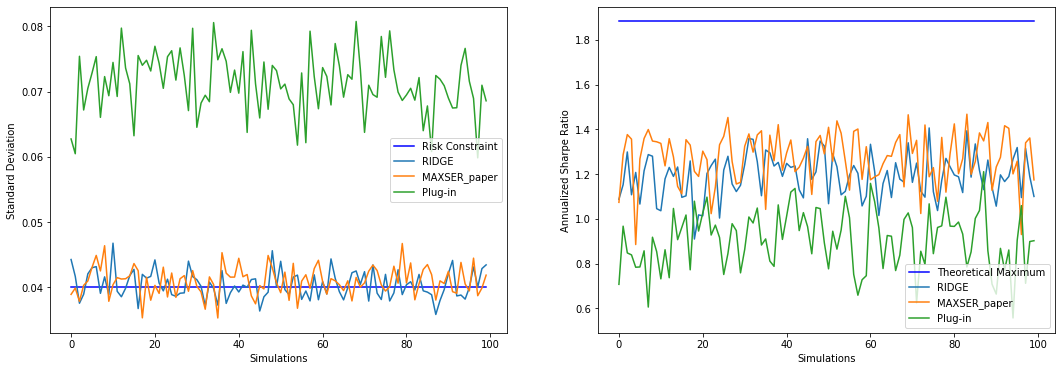

In [141]:
x = range(nobs)
y = np.ones(nobs)
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.plot(x,y*sigma,'b-',x,os_s_ridge, x, os_s_LASSO_paper, x, os_s)
plt.xlabel('Simulations')
plt.ylabel('Standard Deviation')
plt.legend(['Risk Constraint','RIDGE', 'MAXSER_paper', 'Plug-in'])
# plt.show()

# plt.figure(figsize=(8,6))
plt.subplot(1, 2, 2)
plt.plot(x,y*sr,'b-',x,os_sr_ridge, x, os_sr_LASSO_paper, x, os_sr)
plt.xlabel('Simulations')
plt.ylabel('Annualized Sharpe Ratio')
plt.legend(['Theoretical Maximum', 'RIDGE', 'MAXSER_paper', 'Plug-in'])
plt.show()